In [ ]:
#|default_ex ricci
#|hide
import jax
import jax.numpy as jnp
# diffusion curvature stuffs
from diffusion_curvature.diffusion_laziness import entropy_of_diffusion
import pygsp
import jax
import jax.numpy as jnp
from fastcore.all import *
import skdim
import scipy
from inspect import getfullargspec
from typing import Callable, Literal, get_args, get_origin
import graphtools
from tqdm.auto import trange, tqdm

from jax.experimental import sparse

from diffusion_curvature.graphs import diff_aff, diff_op, diffusion_matrix_from_affinities
from diffusion_curvature.heat_diffusion import heat_diffusion_on_signal, kronecker_delta, jax_power_matrix
from diffusion_curvature.diffusion_laziness import wasserstein_spread_of_diffusion, entropy_of_diffusion
from diffusion_curvature.distances import phate_distances_differentiable
from diffusion_curvature.comparison_space import EuclideanComparisonSpace, fit_comparison_space_model, euclidean_comparison_graph, construct_ndgrid_from_shape, diffusion_coordinates, load_average_entropies
from diffusion_curvature.clustering import enhanced_spectral_clustering
from diffusion_curvature.normalizing_flows import neural_flattener
from diffusion_curvature.vne import optimal_t_via_vne
from diffusion_curvature.utils import random_jnparray
import diffusion_curvature

import torch

# import deepdish
import h5py


# Diffusion Ricci Curvature
> Signed curvature without the comparison space

Diffusion curvature is an excellent *unsigned* measure of curvature; it correlates nicely with the scalar curvature, even in high dimensions and amidst noise. But turning that always positive scalar - the measurement of laziness of random walks - into an indicator of positive or negative curvature requires oftentimes unweildy usage of comparison spaces. And comparison spaces depend, to a large degree, on being able to match the sampling and graph construction of the target space, turning signed diffusion curvature from a mathematical problem into a machine learning data-training problem.

This notebook explores an alternate way to make diffusion curvature signed. At its heart is this intuition:
scalar curvature is a *integral* of sorts over the Ricci curvature. Thus, to recover the (signed) Ricci curvature from even an unsigned scalar curvature, one just has to differentiate, asking the question: *does changing the weight of this edge increase or decrease the scalar curvature of the surrounding regions?* If strengthening the edge causes random walks in the surrounding regions to become lazier, the edge has positive curvature. If, e.g., the edge connects two regions of already positive curvature (like two circles), then strengthening it makes the surrounding graph more saddle-like and has negative curvature.

This motivates our definition of *Diffusion Ricci Curvature*. Let $l(A,t)[i] = \sum_j P^t[i,j] \log P^t[i,j]$ be the diffusion laziness of a node $i$ in a graph with affinity matrix $A$. The Diffusion Ricci Curvature $k_{rd}$ of edge $i,j$ is then

$$ 
k_{rd} = \frac{\partial l(A,t)[i]}{\partial A[i,j]} + \frac{\partial l(A,t)[j]}{\partial A[i,j]}
$$

Computing this made possible by the fact the diffusion curvature is differentiable - and we can 'backpropogate' through the multiplications of $P$, much as one can backpropogate through a GNN. Here's a few functions to implement the basics:

# With Diffusion Laziness

First, we'll try the simplest possible version of diffusion curvature: as the probability of a random walk returning to its point of origin.

In [ ]:
def DC_of_idx(A,i,t):
    # remove diagonals of A, so random walks have no laziness
    # A = A.at[jnp.diag_indices_from(A)].set(0)
    P = (A / A.sum(axis=1, keepdims=True))
    Pt = jax_power_matrix(P,t)
    entropy_elementwise = -jax.scipy.special.entr(Pt + 1e-10)
    entropy_of_rows = jnp.sum(entropy_elementwise, axis=-1)
    return entropy_of_rows[i]

In [ ]:
def diffusion_matrix(A):
    # remove diagonals of A, so random walks have no laziness
    # A = A.at[jnp.diag_indices_from(A)].set(0)
    # anisotropic density correction
    # D = jnp.diag(jnp.sum(A, axis=-1)**(-1))
    # A = D @ A @ D
    P = (A / A.sum(axis=1, keepdims=True))
    return P
    
def diffusion_laziness_of_graph(A,t, scale_by_2norm = True):
    P = diffusion_matrix(A)
    Pt = jax_power_matrix(P,t)
    diffusion_laziness = Pt.diagonal() #jnp.sum(Pt * Pt, axis=-1)
    # if scale_by_2norm:
    #     two_norm = (P @ P).diagonal()
    #     diffusion_laziness = diffusion_laziness / two_norm
    return diffusion_laziness
    
def diffusion_laziness_of_idx(A, i, t):
    return diffusion_laziness_of_graph(A,t)[i]
    
def mean_diffusion_laziness_of_graph(A,t):
    return jnp.mean(diffusion_laziness_of_graph(A,t))

def diffusion_laziness_of_edge(A, i, j, t):
    return diffusion_laziness_of_idx(A, i, t) + diffusion_laziness_of_idx(A, j, t)

In [ ]:
def edge_surgery(A,i,j,epsilon):
    # returns A with edges i,j and j,i increased by epsilon
    diager = jnp.zeros_like(A)
    diager = diager.at[[i,j],[j,i]].set(1)
    A = A + epsilon*diager

def dc_of_edge_with_surgery(A, i, j, t, epsilon):
    A_surgery = edge_surgery(A, i, j, epsilon)
    return diffusion_laziness_of_edge(A_surgery, i, j, t)
    
def differential_dc_of_edge(A,i,j,t):
    # return jax.grad(DC_of_idx)(A,i,t)[i][j]+jax.grad(DC_of_idx)(A,j,t)[i][j]
    # return jax.grad(diffusion_laziness_of_idx)(A,i,t)[i][j]+jax.grad(DC_of_idx)(A,j,t)[i][j]
    # return jax.grad(diffusion_laziness_of_edge)(A, i, j, t)[i][j]
    return jax.grad(mean_diffusion_laziness_of_graph)(A, t)[i][j]

In [ ]:
from tqdm.auto import trange
def differential_dc(A,t, eps=1e-8):
    # return a matrix of the edge wise diffusion curvatures for all edges
    # (i,j) is the edge from i to j
    A = jnp.array(A, dtype=jnp.float32)
    R = jnp.zeros(A.shape)
    edges_used = jnp.zeros(A.shape)
    for i in trange(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i,j] > eps:
                R = R.at[i,j].set(differential_dc_of_edge(A,i,j,t))
                edges_used = edges_used.at[i,j].set(1)
    return R, edges_used

In [ ]:
#|hide
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def plot_graph_with_edge_and_node_colors(A, R=None, N=None):
    # Convert adjacency matrix to graph
    G = nx.from_numpy_array(A)

    # Apply min-max scaling to R and N, filling with zeros if not provided
    min_val_R, max_val_R = (np.min(R), np.max(R)) if R is not None else (0, 1)
    normalized_R = (R - min_val_R) / (max_val_R - min_val_R) if R is not None else np.zeros_like(A)

    min_val_N, max_val_N = (np.min(N), np.max(N)) if N is not None else (0, 1)
    normalized_N = (N - min_val_N) / (max_val_N - min_val_N) if N is not None else np.zeros(A.shape[0])

    # Choose colormaps
    cmap_edges = plt.cm.viridis
    cmap_nodes = plt.cm.plasma

    # Create lists for edge and node colors based on normalized values
    edge_colors = [cmap_edges(normalized_R[u, v]) for u, v in G.edges()]
    node_colors = [cmap_nodes(normalized_N[u]) for u in G.nodes()]

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot the graph
    pos = nx.spring_layout(G)  # or choose another layout
    nx.draw(G, pos, ax=ax, with_labels=True, edge_color=edge_colors, node_color=node_colors, width=2)

    # Create color bars for edges and nodes, moving one to the left side
    sm_edge = plt.cm.ScalarMappable(cmap=cmap_edges, norm=plt.Normalize(vmin=min_val_R, vmax=max_val_R))
    sm_edge.set_array([])
    cbar_edge = plt.colorbar(sm_edge, ax=ax, orientation='vertical', fraction=0.046, pad=0.08, location='left')
    cbar_edge.set_label('Edge Weights')

    sm_node = plt.cm.ScalarMappable(cmap=cmap_nodes, norm=plt.Normalize(vmin=min_val_N, vmax=max_val_N))
    sm_node.set_array([])
    cbar_node = plt.colorbar(sm_node, ax=ax, orientation='vertical', fraction=0.046, pad=0.08, location='right')
    cbar_node.set_label('Node Weights')


    plt.show()


## A Cube

We'll start with the simplest possible case: an 8 point cube. Here, we can directly visualize what happens when we weaken and strength an edge.

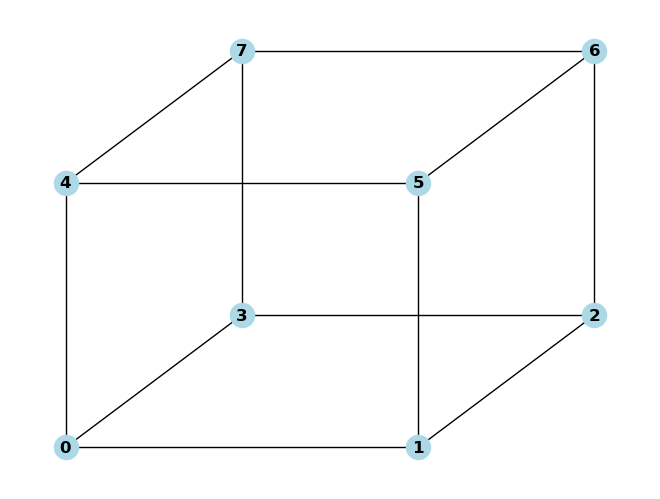

2023-12-01 13:11:10.829263: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [ ]:
#|hide
import networkx as nx
import matplotlib.pyplot as plt

def eight_point_cube_graph():
    # Create an empty graph
    G = nx.Graph()

    # Define vertices of a cube
    vertices = [
        (0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0),
        (0, 0, 1), (1, 0, 1), (1, 1, 1), (0, 1, 1)
    ]
    
    # Add vertices to the graph
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)

    # Define edges of the cube
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]
    
    # Add edges to the graph
    G.add_edges_from(edges)

    # Adjust positions for a 2D plot to make all nodes visible
    pos_2d = {
        0: (0, 0), 1: (1, 0), 2: (1.5, 0.5), 3: (0.5, 0.5),
        4: (0, 1), 5: (1, 1), 6: (1.5, 1.5), 7: (0.5, 1.5)
    }

    # Plot the graph
    nx.draw(G, pos=pos_2d, with_labels=True, node_color='lightblue', font_weight='bold')
    plt.show()

    # Return the adjacency matrix
    return nx.adjacency_matrix(G).todense()

# Example usage
A = jnp.array(eight_point_cube_graph())


In [ ]:
def tweak_matrix_entry(A, i, j, num_ops = 10, max_weakening = 0.5):
    A = jnp.array(A, dtype=float)
    diager = jnp.zeros_like(A)
    diager = diager.at[[i,j],[j,i]].set(1)
    outs = [A + diager*(-max_weakening)]
    # returns a list of new As, with A[i,j] weakened then strengthened
    tweak_amount = 2*max_weakening / num_ops
    tweaks = [-max_weakening]
    for n in range(num_ops):
        outs.append(
            outs[-1] + diager*tweak_amount
        )
        tweaks.append(tweaks[-1] + tweak_amount)
    return outs, tweaks
    

In [ ]:
def plot_curvature_change_along_edge(A, i, j, t, use_mean=True):
    A = jnp.array(A, dtype=float)
    As, tweaks = tweak_matrix_entry(A, i,j, max_weakening=1, num_ops = 30)
    local_diffusion_curvatures = []
    for tweaked_A in As:
        if not use_mean: local_diffusion_curvatures.append(
            diffusion_laziness_of_idx(tweaked_A, i, t) + diffusion_laziness_of_idx(tweaked_A, j, t)
        )
        else: local_diffusion_curvatures.append(
            mean_diffusion_laziness_of_graph(tweaked_A,t)
        )
    plt.plot(tweaks, local_diffusion_curvatures)
    plt.title(f"Change in {t}-step Diffusion Laziness when altering edge [{i},{j}]")

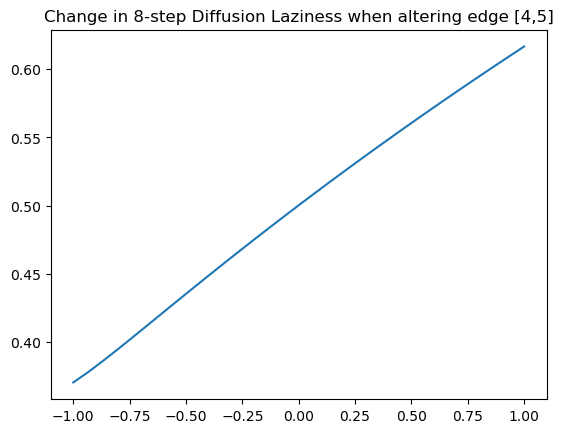

In [ ]:
plot_curvature_change_along_edge(A,4,5,8, use_mean=False)

As expected, we can see the diffusion laziness of nodes 4 and 5 increase as the edge [4,5] is strengthened - a sign of positive curvature.

Interestingly, though the *mean* diffusion laziness across the graph stays virtually constant.

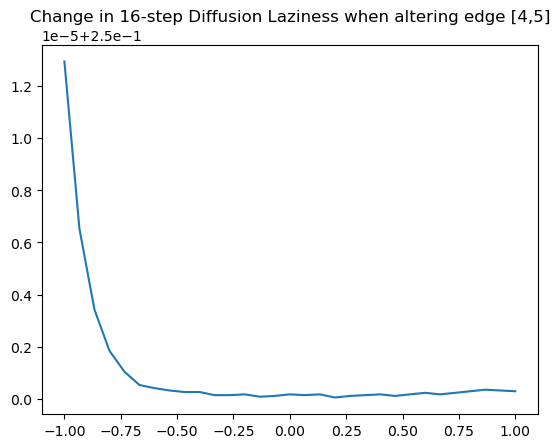

In [ ]:
plot_curvature_change_along_edge(A,4,5,16, use_mean=True)

  0%|          | 0/8 [00:00<?, ?it/s]

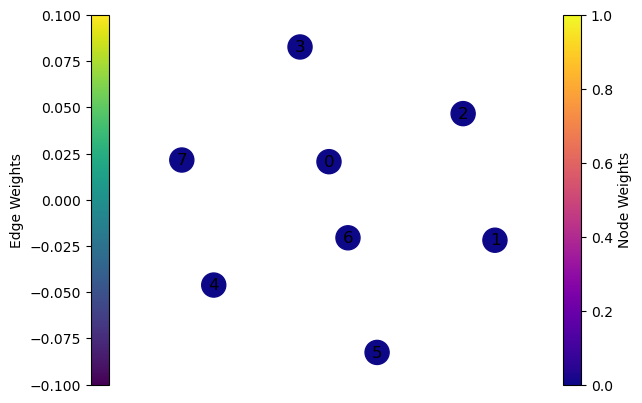

In [ ]:
R, E = differential_dc(A, 8)
plot_graph_with_edge_and_node_colors(A,R=R)

## A Saddle-like Region

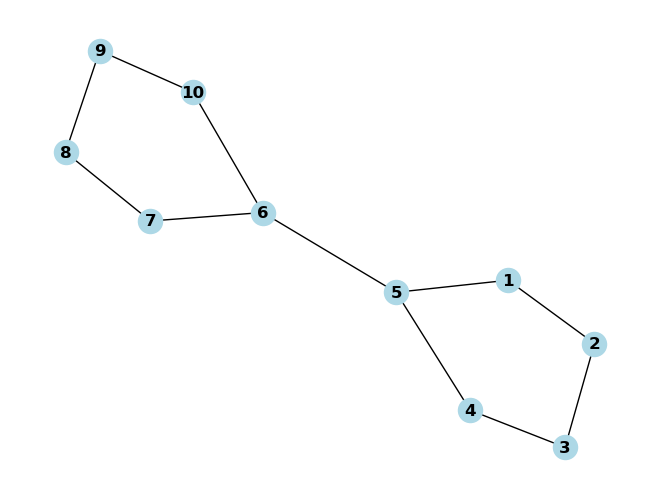

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def saddled_ring_graph(nodes_per_ring):
    # Create an empty graph
    G = nx.Graph()

    # Generate nodes for the first ring
    first_ring = list(range(1, nodes_per_ring + 1))
    G.add_nodes_from(first_ring)
    # Forming the cycle for the first ring
    G.add_edges_from(zip(first_ring, first_ring[1:] + first_ring[:1]))

    # Generate nodes for the second ring
    second_ring = list(range(nodes_per_ring + 1, 2 * nodes_per_ring + 1))
    G.add_nodes_from(second_ring)
    # Forming the cycle for the second ring
    G.add_edges_from(zip(second_ring, second_ring[1:] + second_ring[:1]))

    # Add an edge to connect the two rings
    G.add_edge(nodes_per_ring, nodes_per_ring + 1)

    # Plot the graph
    nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold')
    plt.show()

    # Return the adjacency matrix
    return nx.adjacency_matrix(G).todense()

# Example usage
saddle_A = saddled_ring_graph(5)


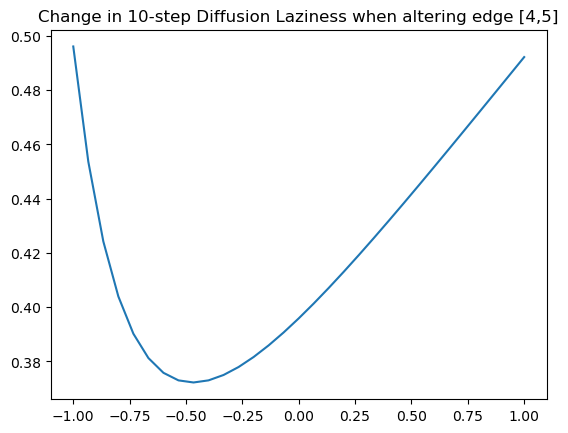

In [ ]:
plot_curvature_change_along_edge(saddle_A, 4, 5, 10, use_mean=False)

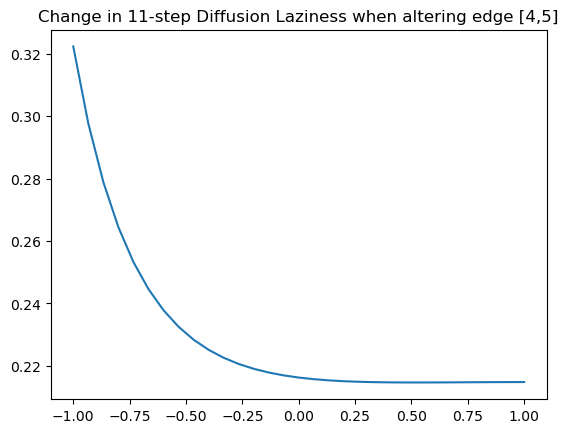

In [ ]:
plot_curvature_change_along_edge(saddle_A, 4, 5, 11, use_mean=False)

# With the saddle, the story is more complex. 

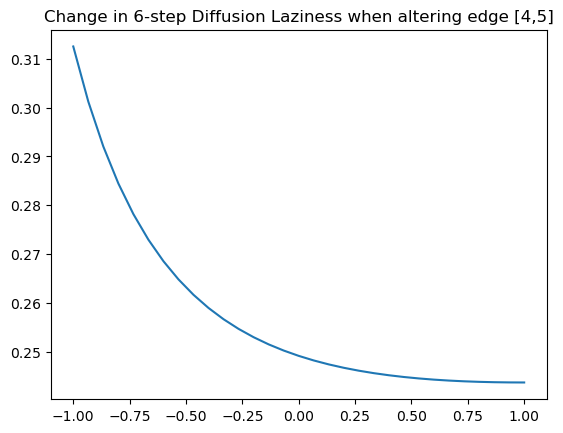

In [ ]:
plot_curvature_change_along_edge(saddle_A, 4, 5, 6, use_mean=True)

In [ ]:
tweaked_saddle_As, tweaks = tweak_matrix_entry(saddle_A,4,5, max_weakening=1)

In [ ]:
tweaked_diffusions = []
for sA in tweaked_saddle_As:
    P = diffusion_matrix(sA)
    Pt = jax_power_matrix(P,16)
    tweaked_diffusions.append(Pt[5])

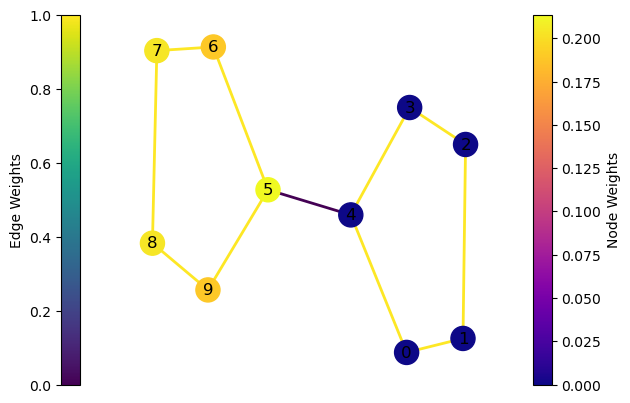

In [ ]:
plot_graph_with_edge_and_node_colors(saddle_A, N=tweaked_diffusions[0],R = tweaked_saddle_As[0])

In [ ]:
diffusion_laziness_of_idx(tweaked_saddle_As[0],4,16)

Array(0.21347046, dtype=float32)

In [ ]:
diffusion_laziness_of_idx(tweaked_saddle_As[0],5,16)

Array(0.21347046, dtype=float32)

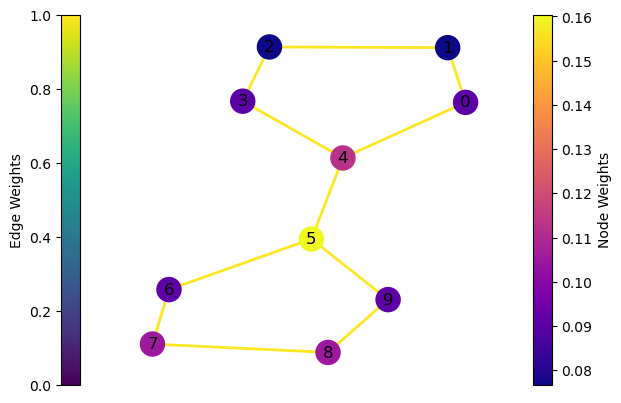

In [ ]:
plot_graph_with_edge_and_node_colors(saddle_A, N=tweaked_diffusions[5], R = tweaked_saddle_As[5])

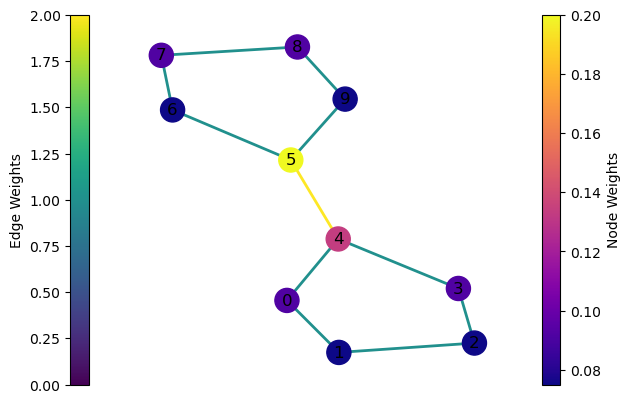

In [ ]:
plot_graph_with_edge_and_node_colors(saddle_A, N=tweaked_diffusions[-1], R = tweaked_saddle_As[-1])

In [ ]:
diffusion_laziness_of_idx(tweaked_saddle_As[5],4,16)

Array(0.16034715, dtype=float32)

In [ ]:
diffusion_laziness_of_idx(tweaked_saddle_As[5],5,16)

Array(0.16034718, dtype=float32)

And here, strengthening this saddle edge decreases the diffusion laziness of the surrounding points -- a sign of negative curvature.

  0%|          | 0/10 [00:00<?, ?it/s]

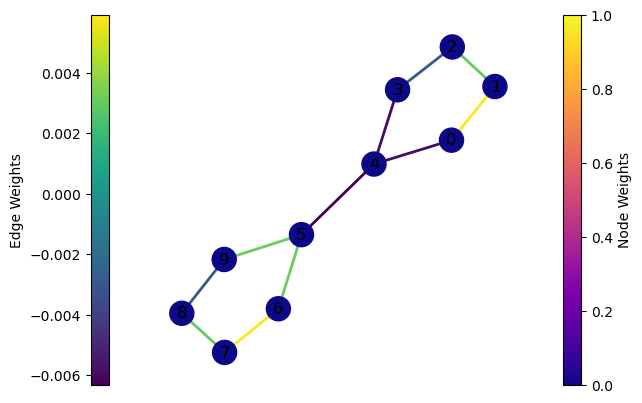

In [ ]:
R, E = differential_dc(saddle_A, 16)
plot_graph_with_edge_and_node_colors(saddle_A,R)

In [ ]:
jax.grad(diffusion_laziness_of_edge)(jnp.array(A,dtype=float), 4, 5, 8)

Array([[-0.15627703, -0.02093177, -0.15627703, -0.0520246 ,  0.07295638,
        -0.15627703, -0.02093177, -0.15627703],
       [-0.02093177, -0.15627703, -0.0520246 , -0.15627703, -0.15627703,
         0.07295638, -0.15627703, -0.02093177],
       [-0.09388816,  0.01036428, -0.09388816, -0.02072855,  0.10364278,
        -0.09388816,  0.01036428, -0.09388816],
       [ 0.01036428, -0.09388816, -0.02072855, -0.09388816, -0.09388816,
         0.10364278, -0.09388816,  0.01036428],
       [-0.03129604, -0.26052946, -0.06299852, -0.26052946, -0.26052946,
         0.06259209, -0.26052946, -0.03129604],
       [-0.26052946, -0.03129604, -0.26052946, -0.06299852,  0.0625921 ,
        -0.26052946, -0.03129604, -0.26052946],
       [-0.02093178, -0.15627705, -0.05202461, -0.15627705, -0.15627705,
         0.07295637, -0.15627705, -0.02093178],
       [-0.15627705, -0.02093178, -0.15627705, -0.05202461,  0.07295638,
        -0.15627705, -0.02093178, -0.15627705]], dtype=float32)

## The challenge
This method works convincingly on exceedingly simple toy data, where changing one edge has a drastic effect on the surrounding region. In this respect, it has many of the weaknesses of Ollivier Ricci curvature. In a densely-sampled manifold, most edges will appear *flat*, in that altering them doesn't much change the geometry. 

## With 300 Point torus

In [ ]:
from diffusion_curvature.datasets import torus
X, ks = torus(200)
G = graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()

In [ ]:
A = jnp.array(
        G.W.todense(),
        dtype=jnp.float32,
    )

In [ ]:
R = differential_dc(A,8)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
scalar_ks = jnp.sum(R[0], axis=-1)

In [ ]:
from diffusion_curvature.utils import plot_3d
plot_3d(X,scalar_ks,colorbar=True,use_plotly=True)

# With Diffusion Entropy

In [ ]:
def DC_of_idx(A,i,t):
    # remove diagonals of A, so random walks have no laziness
    A = A.at[jnp.diag_indices_from(A)].set(0)
    P = (A / A.sum(axis=1, keepdims=True))
    Pt = jax_power_matrix(P,t)
    entropy_elementwise = -jax.scipy.special.entr(Pt + 1e-10)
    entropy_of_rows = jnp.sum(entropy_elementwise, axis=-1)
    return entropy_of_rows[i]

In [ ]:
def diffusion_matrix(A):
    # remove diagonals of A, so random walks have no laziness
    A = A.at[jnp.diag_indices_from(A)].set(0)
    # anisotropic density correction
    # D = jnp.diag(jnp.sum(A, axis=-1)**(-1))
    # A = D @ A @ D
    P = (A / A.sum(axis=1, keepdims=True))
    return P
    
def diffusion_laziness_of_graph(A,t, scale_by_2norm = True):
    P = diffusion_matrix(A)
    Pt = jax_power_matrix(P,t)
    # diffusion_laziness = Pt.diagonal() #jnp.sum(Pt * Pt, axis=-1)
    # if scale_by_2norm:
    #     two_norm = (P @ P).diagonal()
    #     diffusion_laziness = diffusion_laziness / two_norm
    
    entropy_elementwise = -jax.scipy.special.entr(Pt + 1e-10)
    diffusino_laziness = jnp.sum(entropy_elementwise, axis=-1)
    return diffusion_laziness
    
def diffusion_laziness_of_idx(A, i, t):
    return diffusion_laziness_of_graph(A,t)[i]
    
def mean_diffusion_laziness_of_graph(A,t):
    return jnp.mean(diffusion_laziness_of_graph(A,t))

def diffusion_laziness_of_edge(A, i, j, t):
    return diffusion_laziness_of_idx(A, i, t) + diffusion_laziness_of_idx(A, j, t)

In [ ]:
def differential_dc_of_edge(A,i,j,t):
    # return jax.grad(DC_of_idx)(A,i,t)[i][j]+jax.grad(DC_of_idx)(A,j,t)[i][j]
    # return jax.grad(diffusion_laziness_of_idx)(A,i,t)[i][j]+jax.grad(DC_of_idx)(A,j,t)[i][j]
    # return jax.grad(diffusion_laziness_of_edge)(A, i, j, t)[i][j]
    return jax.grad(mean_diffusion_laziness_of_graph)(A, t)[i][j]

In [ ]:
from tqdm.auto import trange
def differential_dc(A,t, eps=1e-8):
    # return a matrix of the edge wise diffusion curvatures for all edges
    # (i,j) is the edge from i to j
    A = jnp.array(A, dtype=jnp.float32)
    R = jnp.zeros(A.shape)
    edges_used = jnp.zeros(A.shape)
    for i in trange(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i,j] > eps:
                R = R.at[i,j].set(differential_dc_of_edge(A,i,j,t))
                edges_used = edges_used.at[i,j].set(1)
    return R, edges_used

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def plot_graph_with_edge_and_node_colors(A, R=None, N=None):
    # Convert adjacency matrix to graph
    G = nx.from_numpy_array(A)

    # Apply min-max scaling to R and N, filling with zeros if not provided
    min_val_R, max_val_R = (np.min(R), np.max(R)) if R is not None else (0, 1)
    normalized_R = (R - min_val_R) / (max_val_R - min_val_R) if R is not None else np.zeros_like(A)

    min_val_N, max_val_N = (np.min(N), np.max(N)) if N is not None else (0, 1)
    normalized_N = (N - min_val_N) / (max_val_N - min_val_N) if N is not None else np.zeros(A.shape[0])

    # Choose colormaps
    cmap_edges = plt.cm.viridis
    cmap_nodes = plt.cm.plasma

    # Create lists for edge and node colors based on normalized values
    edge_colors = [cmap_edges(normalized_R[u, v]) for u, v in G.edges()]
    node_colors = [cmap_nodes(normalized_N[u]) for u in G.nodes()]

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot the graph
    pos = nx.spring_layout(G)  # or choose another layout
    nx.draw(G, pos, ax=ax, with_labels=True, edge_color=edge_colors, node_color=node_colors, width=2)

    # Create color bars for edges and nodes
    sm_edge = plt.cm.ScalarMappable(cmap=cmap_edges, norm=plt.Normalize(vmin=min_val_R, vmax=max_val_R))
    sm_edge.set_array([])
    cbar_edge = plt.colorbar(sm_edge, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)
    cbar_edge.set_label('Edge Weights')

    sm_node = plt.cm.ScalarMappable(cmap=cmap_nodes, norm=plt.Normalize(vmin=min_val_N, vmax=max_val_N))
    sm_node.set_array([])
    cbar_node = plt.colorbar(sm_node, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)
    cbar_node.set_label('Node Weights')

    plt.show()


## A Cube

We'll start with the simplest possible case: an 8 point cube. Here, we can directly visualize what happens when we weaken and strength an edge.

In [ ]:
#|hide
import networkx as nx
import matplotlib.pyplot as plt

def eight_point_cube_graph():
    # Create an empty graph
    G = nx.Graph()

    # Define vertices of a cube
    vertices = [
        (0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0),
        (0, 0, 1), (1, 0, 1), (1, 1, 1), (0, 1, 1)
    ]
    
    # Add vertices to the graph
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)

    # Define edges of the cube
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]
    
    # Add edges to the graph
    G.add_edges_from(edges)

    # Adjust positions for a 2D plot to make all nodes visible
    pos_2d = {
        0: (0, 0), 1: (1, 0), 2: (1.5, 0.5), 3: (0.5, 0.5),
        4: (0, 1), 5: (1, 1), 6: (1.5, 1.5), 7: (0.5, 1.5)
    }

    # Plot the graph
    nx.draw(G, pos=pos_2d, with_labels=True, node_color='lightblue', font_weight='bold')
    plt.show()

    # Return the adjacency matrix
    return nx.adjacency_matrix(G).todense()

# Example usage
A = jnp.array(eight_point_cube_graph())


In [ ]:
def tweak_matrix_entry(A, i, j, num_ops = 10, max_weakening = 0.5):
    A = jnp.array(A, dtype=float)
    diager = jnp.zeros_like(A)
    diager = diager.at[[i,j],[j,i]].set(1)
    outs = [A + diager*(-max_weakening)]
    # returns a list of new As, with A[i,j] weakened then strengthened
    tweak_amount = 2*max_weakening / num_ops
    tweaks = [-max_weakening]
    for n in range(num_ops):
        outs.append(
            outs[-1] + diager*tweak_amount
        )
        tweaks.append(tweaks[-1] + tweak_amount)
    return outs, tweaks
    

In [ ]:
def plot_curvature_change_along_edge(A, i, j, t, use_mean=True):
    A = jnp.array(A, dtype=float)
    As, tweaks = tweak_matrix_entry(A, i,j, max_weakening=1, num_ops = 30)
    local_diffusion_curvatures = []
    for tweaked_A in As:
        if not use_mean: local_diffusion_curvatures.append(
            diffusion_laziness_of_idx(tweaked_A, i, t) + diffusion_laziness_of_idx(tweaked_A, j, t)
        )
        else: local_diffusion_curvatures.append(
            mean_diffusion_laziness_of_graph(tweaked_A,t)
        )
    plt.plot(tweaks, local_diffusion_curvatures)
    plt.title(f"Change in {t}-step Diffusion Laziness when altering edge [{i},{j}]")

In [ ]:
plot_curvature_change_along_edge(A,4,5,8, use_mean=False)

As expected, we can see the diffusion laziness increasing as the edge [4,5] is strengthened - a sign of positive curvature.

Indeed, the Diffusion Ricci curvature of the edges is uniformly positive.

In [ ]:
plot_curvature_change_along_edge(A,4,5,16, use_mean=True)

In [ ]:
R, E = differential_dc(A, 8)
plot_graph_with_edge_colors(A,R)

In [ ]:
jnp.min(R)

## A Saddle-like Region

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def saddled_ring_graph(nodes_per_ring):
    # Create an empty graph
    G = nx.Graph()

    # Generate nodes for the first ring
    first_ring = list(range(1, nodes_per_ring + 1))
    G.add_nodes_from(first_ring)
    # Forming the cycle for the first ring
    G.add_edges_from(zip(first_ring, first_ring[1:] + first_ring[:1]))

    # Generate nodes for the second ring
    second_ring = list(range(nodes_per_ring + 1, 2 * nodes_per_ring + 1))
    G.add_nodes_from(second_ring)
    # Forming the cycle for the second ring
    G.add_edges_from(zip(second_ring, second_ring[1:] + second_ring[:1]))

    # Add an edge to connect the two rings
    G.add_edge(nodes_per_ring, nodes_per_ring + 1)

    # Plot the graph
    nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold')
    plt.show()

    # Return the adjacency matrix
    return nx.adjacency_matrix(G).todense()

# Example usage
saddle_A = saddled_ring_graph(5)


In [ ]:
plot_curvature_change_along_edge(saddle_A, 4, 5, 16, use_mean=False)

In [ ]:
plot_curvature_change_along_edge(saddle_A, 4, 5, 16, use_mean=True)

In [ ]:
tweaked_saddle_As, tweaks = tweak_matrix_entry(saddle_A,4,5, max_weakening=1)

In [ ]:
tweaked_diffusions = []
for sA in tweaked_saddle_As:
    P = diffusion_matrix(sA)
    Pt = jax_power_matrix(P,16)
    tweaked_diffusions.append(Pt[5])

In [ ]:
plot_graph_with_edge_and_node_colors(saddle_A, N=tweaked_diffusions[0])

In [ ]:
diffusion_laziness_of_idx(tweaked_saddle_As[0],4,16)

In [ ]:
diffusion_laziness_of_idx(tweaked_saddle_As[0],5,16)

In [ ]:
plot_graph_with_edge_and_node_colors(saddle_A, N=tweaked_diffusions[5])

In [ ]:
plot_graph_with_edge_and_node_colors(saddle_A, N=tweaked_diffusions[-1])

In [ ]:
diffusion_laziness_of_idx(tweaked_saddle_As[5],4,16)

In [ ]:
diffusion_laziness_of_idx(tweaked_saddle_As[5],5,16)

And here, strengthening this saddle edge decreases the diffusion laziness of the surrounding points -- a sign of negative curvature.

In [ ]:
R, E = differential_dc(saddle_A, 16)
plot_graph_with_edge_colors(saddle_A,R)

In [ ]:
jax.grad(diffusion_laziness_of_edge)(jnp.array(A,dtype=float), 4, 5, 8)

## The challenge
This method works convincingly on exceedingly simple toy data, where changing one edge has a drastic effect on the surrounding region. In this respect, it has many of the weaknesses of Ollivier Ricci curvature. In a densely-sampled manifold, most edges will appear *flat*, in that altering them doesn't much change the geometry. 

## With 300 Point torus

In [ ]:
from diffusion_curvature.datasets import torus
X, ks = torus(200)
G = graphtools.Graph(X, anisotropy=1, knn=15, decay=None).to_pygsp()

In [ ]:
A = jnp.array(
        G.W.todense(),
        dtype=jnp.float32,
    )

In [ ]:
R = differential_dc(A,8)

In [ ]:
scalar_ks = jnp.sum(R[0], axis=-1)

In [ ]:
from diffusion_curvature.utils import plot_3d
plot_3d(X,scalar_ks,colorbar=True,use_plotly=True)